# 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re

import scipy
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.optim import *
from torch.optim.lr_scheduler import *

import os 
import glob
import cv2
import itertools
from copy import deepcopy
from fast_pytorch_kmeans import KMeans

from collections import namedtuple
from torch.nn import parameter


from dataloader import *
from model import *

# Train

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

conv1d_dim1 = 32
conv1d_dim2 = 64
conv1d_dim3 = 128
dense_dim = 256

learning_rate = 0.001
n_epochs = 2000

criterion_mse = nn.MSELoss()

In [3]:
# 경로 입력 및 아이디 추출
random_seed = 77
np.random.seed(random_seed) # numpy
random.seed(random_seed) # random

file_path = "/home/taeoowl/gait/data/total/"
data_path = glob.glob(file_path + '*')
name = []
for file_name in data_path:
    folder_name = os.path.split(file_name)[1][:7]
    name += [folder_name]
    
id_name = np.unique(name)

# trn/val/tst으로 사용할 id 추출
# 남녀 각각 2명씩 보폭이 큰 사람(Q1)과 작은 사람(Q3)을 기준
test_id = np.array(['IF03014', 'IF00041', 'IM02040', 'IM98049'])

id_name_trnval = np.setdiff1d(id_name, test_id)
valid_id = np.random.choice(id_name_trnval, size=4, replace=False)

train_id = np.setdiff1d(id_name, np.hstack([test_id, valid_id]))

print('Train ID : {}\n Valid ID {}'.format(train_id, valid_id))

Train ID : ['IF00017' 'IF00024' 'IF01020' 'IF01045' 'IF01047' 'IF02035' 'IF03027'
 'IF99008' 'IF99013' 'IF99030' 'IF99032' 'IM01006' 'IM01029' 'IM03011'
 'IM03048' 'IM96018' 'IM96033' 'IM97015' 'IM98009' 'IM98026' 'IM98036'
 'IM98042' 'IM98050' 'IM99007' 'IM99010' 'IM99012' 'IM99021' 'IM99025'
 'IM99037']
 Valid ID ['IF00034' 'IM98019' 'IF03039' 'IF94031']


In [4]:
# seed 고정
torch.manual_seed(random_seed) # torch 
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True # cudnn
torch.backends.cudnn.benchmark = False # cudnn
np.random.seed(random_seed) # numpy
random.seed(random_seed) # random



train_dataset_R = Gait_Dataset_Salted(file_path, train_id, right=True)
train_dataset_L = Gait_Dataset_Salted(file_path, train_id, right=False)

valid_dataset_R = Gait_Dataset_Salted(file_path, valid_id, right=True)
valid_dataset_L = Gait_Dataset_Salted(file_path, valid_id, right=False)

train_dataset = torch.utils.data.ConcatDataset([train_dataset_R, train_dataset_L])
valid_dataset = torch.utils.data.ConcatDataset([valid_dataset_R, valid_dataset_L])

train_loader = torch.utils.data.DataLoader(train_dataset,
                                       batch_size=128,
                                       shuffle=True,
                                       worker_init_fn=np.random.seed(42))
val_loader = torch.utils.data.DataLoader(valid_dataset,
                                         batch_size=128,
                                         shuffle=False)

print('Dataloader Load Complete')



model = Encoder(conv1d_dim1, conv1d_dim2, conv1d_dim3, dense_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Early Stopping을 위한 변수
best = 10000
converge_cnt = 0
best_MAE = 0
best_corr = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0

    # Train Mode
    model.train()

    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_acc, inputs_gyr, inputs_prs, stride_length, mu, sigma, folder_id = data
        inputs_acc, inputs_gyr, inputs_prs, stride_length = inputs_acc.float(), inputs_gyr.float(), inputs_prs.float(), stride_length.float()
        inputs_acc, inputs_gyr, inputs_prs = inputs_acc.to(device), inputs_gyr.to(device), inputs_prs.to(device)

        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_acc, inputs_gyr, inputs_prs)

        # Loss 계산
        loss = criterion_mse(outputs, stride_length)


        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()


        # Print statistics
        tot_trn_loss += loss.item()

    # Evaluation Mode
    model.eval()

    tot_val_loss = 0
    tot_val_MAE = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_acc, inputs_gyr, inputs_prs, stride_length, mu, sigma, folder_id = data
            inputs_acc, inputs_gyr, inputs_prs, stride_length = inputs_acc.float(), inputs_gyr.float(), inputs_prs.float(), stride_length.float()
            inputs_acc, inputs_gyr, inputs_prs = inputs_acc.to(device), inputs_gyr.to(device), inputs_prs.to(device)

            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_acc, inputs_gyr, inputs_prs)

            # Loss 계산
            loss = criterion_mse(outputs, stride_length)

            tot_val_loss += loss.item()
            tot_val_MAE += torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)


    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = tot_val_MAE / len(val_loader)    

    print("Epoch : {}/{}, Train Loss : {:.3f}, Valid Loss {:.3f}, MAE {:.3f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss, MAE))

    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_epoch = epoch+1
        
        checkpoint = {
            'state_dict': model.state_dict(),  # 모델 가중치
            'optimizer_state_dict': optimizer.state_dict(),  # 옵티마이저 상태
            'epoch': best_epoch,  # 에폭 정보
            'loss': best  # 마지막 손실 값
}
        torch.save(checkpoint, './model/pruning/model_origin.pth')  
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1

    if converge_cnt > 50:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:.3f}, MAE {:.3f}'.format(best_epoch, best, best_MAE))
        break



Dataloader Load Complete
Epoch : 1/2000, Train Loss : 4025.449, Valid Loss 3172.665, MAE 55.104
Best Valid Loss 3172.6653
Epoch : 2/2000, Train Loss : 226.493, Valid Loss 382.221, MAE 14.612
Best Valid Loss 382.2212
Epoch : 3/2000, Train Loss : 112.556, Valid Loss 211.437, MAE 12.987
Best Valid Loss 211.4369
Epoch : 4/2000, Train Loss : 99.351, Valid Loss 149.094, MAE 11.024
Best Valid Loss 149.0940
Epoch : 5/2000, Train Loss : 79.809, Valid Loss 162.825, MAE 11.592
Epoch : 6/2000, Train Loss : 60.658, Valid Loss 84.662, MAE 7.992
Best Valid Loss 84.6622
Epoch : 7/2000, Train Loss : 46.926, Valid Loss 108.191, MAE 8.975
Epoch : 8/2000, Train Loss : 42.095, Valid Loss 90.586, MAE 8.178
Epoch : 9/2000, Train Loss : 46.033, Valid Loss 72.532, MAE 7.170
Best Valid Loss 72.5319
Epoch : 10/2000, Train Loss : 42.402, Valid Loss 64.634, MAE 6.451
Best Valid Loss 64.6344
Epoch : 11/2000, Train Loss : 39.075, Valid Loss 68.220, MAE 6.526
Epoch : 12/2000, Train Loss : 36.378, Valid Loss 45.621, M

# Visualize

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

test_file_path = "/home/taeoowl/gait/data/total/"

test_dataset_R = Gait_Dataset_Salted(test_file_path, test_id, right=True)
test_dataset_L = Gait_Dataset_Salted(test_file_path, test_id, right=False)

test_dataset = torch.utils.data.ConcatDataset([test_dataset_R, test_dataset_L])

test_loader = torch.utils.data.DataLoader(test_dataset,
                                       batch_size=256,
                                       shuffle=False,
                                       worker_init_fn=np.random.seed(42))

MAE : 5.7073, MAPE : 95.83%, RMSE : 6.9350, RSE : 0.1067


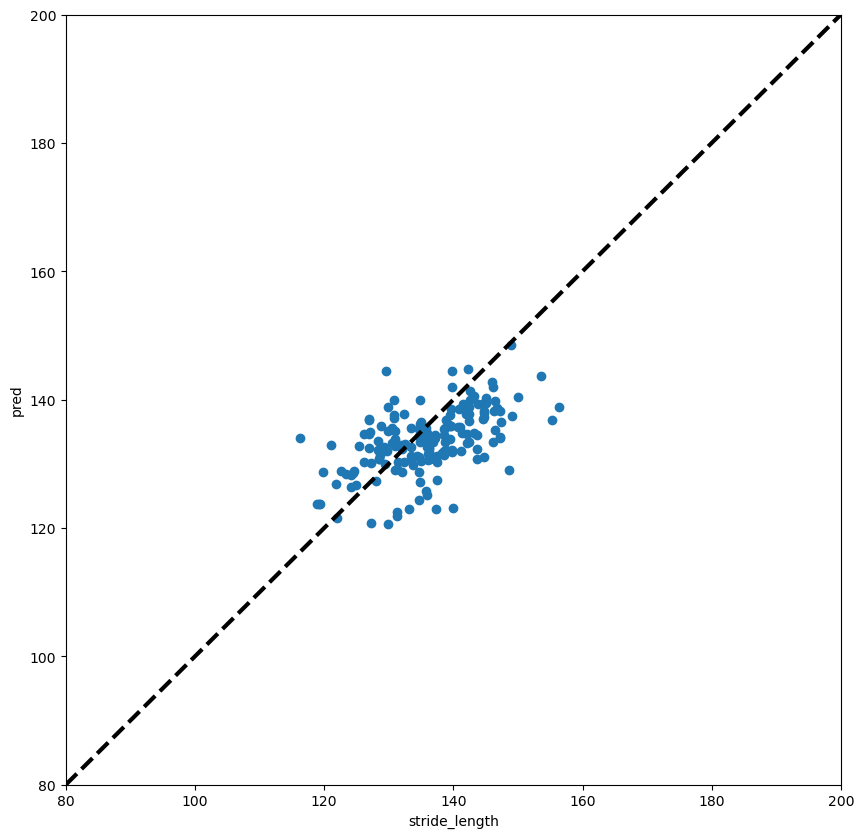

In [6]:
### Scatter Plot 

conv1d_dim1 = 32
conv1d_dim2 = 64
conv1d_dim3 = 128
dense_dim = 256

stride_length_list = pd.DataFrame()
tot_val_MAE = 0
tot_val_MAPE = 0

model_name = './model/pruning/model_origin.pth'

model = Encoder(conv1d_dim1, conv1d_dim2, conv1d_dim3, dense_dim).to(device)
model.load_state_dict(torch.load(model_name)['state_dict'])
# model.load_state_dict(checkpoint['state_dict'])

model.eval()
pred_list = []
for i, data in enumerate(test_loader):
    inputs_acc, inputs_gyr, inputs_prs, stride_length, mu, sigma, folder_id = data
    inputs_acc, inputs_gyr, inputs_prs, stride_length = inputs_acc.float(), inputs_gyr.float(), inputs_prs.float(), stride_length.float() 
    inputs_acc, inputs_gyr, inputs_prs = inputs_acc.to(device), inputs_gyr.to(device), inputs_prs.to(device)

    stride_length = stride_length.reshape(-1, 1)
    stride_length = stride_length.to(device)

    outputs = model(inputs_acc, inputs_gyr, inputs_prs)

pred =  outputs.reshape(-1).cpu().detach().numpy()
stride_length = stride_length.reshape(-1).cpu().detach().numpy()
mu = mu.cpu().detach().numpy()

MAE = np.sum(np.abs(pred - stride_length)) / len(stride_length)
MAPE = 100 - (np.mean(np.abs(pred - stride_length) / stride_length) * 100)
RMSE = np.sqrt(np.mean((stride_length - pred)**2))
RSE = RMSE / np.sqrt(np.sum((stride_length - mu)**2))


print('MAE : {:.4f}, MAPE : {:.2f}%, RMSE : {:.4f}, RSE : {:.4f}'.format(MAE, MAPE, RMSE, RSE))

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, pred)
plt.xlim([80, 200])
plt.xlabel('stride_length')
plt.ylim([80, 200])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

In [28]:
def train(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    scheduler: LambdaLR,
    callbacks = None
) -> None:
    
    model.train()

    for i, data in enumerate(dataloader):
        inputs_acc, inputs_gyr, inputs_prs, stride_length, mu, sigma, folder_id = data
        inputs_acc, inputs_gyr, inputs_prs, stride_length = inputs_acc.float(), inputs_gyr.float(), inputs_prs.float(), stride_length.float() 
        inputs_acc, inputs_gyr, inputs_prs = inputs_acc.to(device), inputs_gyr.to(device), inputs_prs.to(device)

        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        outputs = model(inputs_acc, inputs_gyr, inputs_prs)        
        
        loss = criterion(outputs, stride_length)

        # Backward propagation
        loss.backward()

        # Update optimizer and LR scheduler
        optimizer.step()
        scheduler.step()

        if callbacks is not None:
            for callback in callbacks:
                callback()

In [29]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  extra_preprocess = None
) -> float:
    model.eval()
    
    num_samples = 0
    num_correct = 0

    for i, data in enumerate(dataloader):
        inputs_acc, inputs_gyr, inputs_prs, stride_length, mu, sigma, folder_id = data
        inputs_acc, inputs_gyr, inputs_prs, stride_length = inputs_acc.float(), inputs_gyr.float(), inputs_prs.float(), stride_length.float() 
        inputs_acc, inputs_gyr, inputs_prs = inputs_acc.to(device), inputs_gyr.to(device), inputs_prs.to(device)

        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        outputs = model(inputs_acc, inputs_gyr, inputs_prs)        
        
    pred = outputs.reshape(-1).cpu().detach().numpy()
    stride_length = stride_length.reshape(-1).cpu().detach().numpy()
    mu = mu.cpu().detach().numpy()

    MAE = np.sum(np.abs(pred - stride_length)) / len(stride_length)
    return MAE

In [30]:
def get_model_size(model: nn.Module, data_width=32):
    """
    calculate the model size in bits
    :param data_width: #bits per element
    """
    num_elements = 0
    for param in model.parameters():
        num_elements += param.numel()
    return num_elements * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [49]:
fp32_model_accuracy = evaluate(model, test_loader)
fp32_model_size = get_model_size(model)
print(f"fp32 model has MAE={fp32_model_accuracy:.2f}")
print(f"fp32 model has size={fp32_model_size/MiB:.2f} MiB")

fp32 model has MAE=5.71
fp32 model has size=83.56 MiB


In [50]:
class KMeansQuantizer:
    def __init__(self, model : nn.Module, bitwidth=4):
        self.codebook = KMeansQuantizer.quantize(model, bitwidth)

    @torch.no_grad()
    def apply(self, model, update_centroids):
        for name, param in model.named_parameters():
            if name in self.codebook:
                if update_centroids:
                    update_codebook(param, codebook=self.codebook[name])
                self.codebook[name] = k_means_quantize(
                    param, codebook=self.codebook[name])

    @staticmethod
    @torch.no_grad()
    def quantize(model: nn.Module, bitwidth=4):
        codebook = dict()
        if isinstance(bitwidth, dict):
            for name, param in model.named_parameters():
                if name in bitwidth:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth[name])
        else:
            for name, param in model.named_parameters():
                if param.dim() > 1:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth)
        return codebook

In [73]:
checkpoint_url = "./model/pruning/model_origin.pth"
checkpoint = torch.load(checkpoint_url, map_location="cpu")
model = Encoder(conv1d_dim1, conv1d_dim2, conv1d_dim3, dense_dim).cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda : model.load_state_dict(checkpoint['state_dict'])

=> loading checkpoint './model/pruning/model_origin.pth'


In [74]:
def k_means_quantize(fp32_tensor: torch.Tensor, bitwidth=4, codebook=None):
    """
    Quantize tensor using k-means clustering.
    :param fp32_tensor: [torch.Tensor] Input tensor to be quantized.
    :param bitwidth: [int] Quantization bit width, default=4.
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor).
    :return:
        [Codebook = (centroids, labels)]
            centroids: [torch.(cuda.)FloatTensor] The cluster centroids.
            labels: [torch.(cuda.)LongTensor] Cluster label tensor.
    """
    if codebook is None:
        # Calculate the number of clusters based on the quantization bit width.
        n_clusters = 2 ** bitwidth  # 2^bitwidth clusters.

        # Perform k-means clustering to find centroids and assign labels to input tensor elements.
        kmeans = KMeans(n_clusters=n_clusters, mode='euclidean', verbose=0)
        labels = kmeans.fit_predict(fp32_tensor.view(-1, 1)).to(torch.long)  # Cluster assignment for each element.
        centroids = kmeans.centroids.to(torch.float).view(-1)  # Cluster centroids.

        # Create a codebook containing centroids and labels.
        codebook = Codebook(centroids, labels)

    # Decode the codebook into a quantized tensor for inference.
    quantized_tensor = codebook.centroids[codebook.labels]  # Map labels to corresponding centroid values.

    # Update the input tensor with the quantized values, matching its original shape.
    fp32_tensor.set_(quantized_tensor.view_as(fp32_tensor))

    return codebook

In [75]:
class KMeansQuantizer:
    def __init__(self, model : nn.Module, bitwidth=4):
        self.codebook = KMeansQuantizer.quantize(model, bitwidth)

    @torch.no_grad()
    def apply(self, model, update_centroids):
        for name, param in model.named_parameters():
            if name in self.codebook:
                if update_centroids:
                    update_codebook(param, codebook=self.codebook[name])
                self.codebook[name] = k_means_quantize(
                    param, codebook=self.codebook[name])

    @staticmethod
    @torch.no_grad()
    def quantize(model: nn.Module, bitwidth=4):
        codebook = dict()
        if isinstance(bitwidth, dict):
            for name, param in model.named_parameters():
                if name in bitwidth:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth[name])
        else:
            for name, param in model.named_parameters():
                if param.dim() > 1:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth)
        return codebook

In [76]:

Codebook = namedtuple('Codebook', ['centroids', 'labels'])

print('Note that the storage for codebooks is ignored when calculating the model size.')
quantizers = dict()
for bitwidth in [4, 2]:
    recover_model()
    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer = KMeansQuantizer(model, bitwidth)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
#     quantized_model_accuracy = evaluate(model, dataloader['test'])
#     print(f"    {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}%")
    quantizers[bitwidth] = quantizer

Note that the storage for codebooks is ignored when calculating the model size.
k-means quantizing model into 4 bits
    4-bit k-means quantized model has size=10.45 MiB
k-means quantizing model into 2 bits
    2-bit k-means quantized model has size=5.22 MiB


In [77]:
def update_codebook(fp32_tensor: torch.Tensor, codebook: Codebook):
    """
    Update the centroids in the codebook using updated fp32_tensor.
    :param fp32_tensor: [torch.(cuda.)Tensor] The updated full-precision tensor.
    :param codebook: [Codebook] Contains the cluster centroids and the cluster label tensor.
    """
    n_clusters = codebook.centroids.numel()
    fp32_tensor = fp32_tensor.view(-1)
    for k in range(n_clusters):
        # Update each centroid based on the average of all weights assigned to the corresponding cluster.
        codebook.centroids[k] = fp32_tensor[codebook.labels == k].mean()

In [78]:
import copy

accuracy_drop_threshold = 0.5
quantizers_before_finetune = copy.deepcopy(quantizers)
quantizers_after_finetune = quantizers

for bitwidth in [4, 2]:
    recover_model()
    quantizer = quantizers[bitwidth]
    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer.apply(model, update_centroids=False)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = evaluate(model, test_loader)
    print(f"    {bitwidth}-bit k-means quantized model has MAE={quantized_model_accuracy:.2f} before quantization-aware training ")
    accuracy_drop = np.abs(fp32_model_accuracy - quantized_model_accuracy)
    if accuracy_drop > accuracy_drop_threshold:
        print(f"        Quantization-aware training due to MAE drop={accuracy_drop:.2f} is larger than threshold={accuracy_drop_threshold:.2f}")
        num_finetune_epochs = 20
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
        criterion = nn.MSELoss()
        best_accuracy = float('inf')
        epoch = num_finetune_epochs
        while accuracy_drop > accuracy_drop_threshold and epoch > 0:
            train(model, train_loader, criterion, optimizer, scheduler,
                  callbacks=[lambda: quantizer.apply(model, update_centroids=True)])
            model_accuracy = np.abs(evaluate(model, test_loader))
            is_best = model_accuracy < best_accuracy
            best_accuracy = min(model_accuracy, best_accuracy)
            print(f'        Epoch {num_finetune_epochs-epoch} MAE {model_accuracy:.2f} / Best MAE: {best_accuracy:.2f}')
            accuracy_drop = fp32_model_accuracy - best_accuracy
            epoch -= 1
    else:
        print(f"        No need for quantization-aware training since MAE drop={accuracy_drop:.2f} is smaller than threshold={accuracy_drop_threshold:.2f}")

k-means quantizing model into 4 bits
    4-bit k-means quantized model has size=10.45 MiB
    4-bit k-means quantized model has MAE=16.00 before quantization-aware training 
        Quantization-aware training due to MAE drop=10.29 is larger than threshold=0.50
        Epoch 0 MAE 4883293549.29 / Best MAE: 4883293549.29
k-means quantizing model into 2 bits
    2-bit k-means quantized model has size=5.22 MiB
    2-bit k-means quantized model has MAE=52.11 before quantization-aware training 
        Quantization-aware training due to MAE drop=46.41 is larger than threshold=0.50
        Epoch 0 MAE 1212860092.63 / Best MAE: 1212860092.63
